**Dependencies and setup**

This can take a minute or so...

In [1]:
%%capture
!apt update
!apt install xvfb -y
!pip install 'swig'
!pip install 'pyglet==1.5.27'
!pip install 'gym[box2d]==0.20.0'
!pip install 'pyvirtualdisplay==3.0'

import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
%matplotlib inline

display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plot_interval = 10 # update the plot every N episodes
video_every = 25 # videos can take a very long time to render so only do it every N episodes

**Reinforcement learning agent**

Replace this with your own agent - I recommend starting with TD3 (lecture 8)

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )


class GaussianExploration(object):
    def __init__(self, action_space, max_sigma=1, min_sigma=0.1, decay_period=100000):
        self.low  = action_space.low
        self.high = action_space.high
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
    
    def get_action(self, action, t=0):
        sigma  = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        action = action + np.random.normal(size=len(action)) * sigma
        return np.clip(action, self.low, self.high)

# https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/gaussian_strategy.py

class DecayingOUExploration(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, sigma=0.3, max_sigma=1.0, min_sigma=0.1, decay_period=100000):
        self.low = action_space.low
        self.high = action_space.high
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.x = np.ones(len(self.low)) * self.mu

    def get_action(self, action, t=0):
        sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        dx = self.theta * (self.mu - self.x)
        dx = dx + sigma * np.random.normal(size=len(action))
        self.x = self.x + dx
        action = action + self.x
        return np.clip(action, self.low, self.high)

    


# A and C        
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0]

#https://github.com/higgsfield/RL-Adventure-2
# --------------------------------------------------------------------------------------
env = gym.make("BipedalWalker-v3")
# env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3

# noise = GaussianExploration(env.action_space)
noise = DecayingOUExploration(env.action_space)
# parameter
state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256
policy_lr = 5e-4
value_lr  = 5e-4
soft_tau=1e-2

value_net1 = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
value_net2 = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

target_value_net1 = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_value_net2 = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

soft_update(value_net1, target_value_net1, soft_tau=soft_tau)
soft_update(value_net2, target_value_net2, soft_tau=soft_tau)
soft_update(policy_net, target_policy_net, soft_tau=soft_tau)


value_criterion = nn.MSELoss()



value_optimizer1 = optim.Adam(value_net1.parameters(), lr=value_lr)
value_optimizer2 = optim.Adam(value_net2.parameters(), lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

batch_size  = 64

# ---------------------------------------------------------------------------------------------
#update 
def td3_update(step,
           batch_size,
           gamma = 0.98,
           soft_tau=1e-2,
           noise_std = 0.2,
           noise_clip=0.5,
           policy_update=2,
          ):

    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    next_action = target_policy_net(next_state)
    noise = torch.normal(torch.zeros(next_action.size()), noise_std).to(device)
    noise = torch.clamp(noise, -noise_clip, noise_clip)
    next_action += noise

    target_q_value1  = target_value_net1(next_state, next_action)
    target_q_value2  = target_value_net2(next_state, next_action)
    target_q_value   = torch.min(target_q_value1, target_q_value2)
    expected_q_value = reward + (1.0 - done) * gamma * target_q_value

    q_value1 = value_net1(state, action)
    q_value2 = value_net2(state, action)

    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())

    value_optimizer1.zero_grad()
    value_loss1.backward()
    value_optimizer1.step()

    value_optimizer2.zero_grad()
    value_loss2.backward()
    value_optimizer2.step()

    if step % policy_update == 0:
        policy_loss = value_net1(state, policy_net(state))
        policy_loss = -policy_loss.mean()

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        soft_update(value_net1, target_value_net1, soft_tau=soft_tau)
        soft_update(value_net2, target_value_net2, soft_tau=soft_tau)
        soft_update(policy_net, target_policy_net, soft_tau=soft_tau)



**Prepare the environment and wrap it to capture videos**

In [3]:
%%capture
# env = gym.make("BipedalWalker-v3")
# env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

In [4]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The environment has 24 observations and the agent can take 4 actions
The device is: cuda
It's recommended to train on the cpu for this


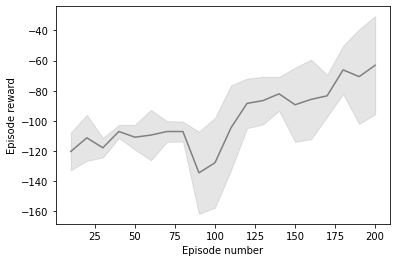

In [ ]:
# in the submission please use seed 42 for verification
seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

# logging variables
ep_reward = 0
reward_list = []
plot_data = []
log_f = open("agent-log.txt","w+")

# initialise agent
max_episodes = 1000
max_timesteps = 2000

# explorationsteps = 400
# training procedure:
for episode in range(1, max_episodes+1):
    state = env.reset()
    for t in range(max_timesteps):

        # select the agent action
        action = policy_net.get_action(state)
        # if t < explorationsteps:
        #   action = noise.get_action(action, t)


        # take action in environment and get r and s'
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            action = noise.get_action(action, episode)
            td3_update(t, batch_size)

        state = next_state
        ep_reward += reward
        
        # stop iterating when the episode finished
        if done or t==(max_timesteps-1):
            break
    
    # append the episode reward to the reward list
    reward_list.append(ep_reward)

    # do NOT change this logging code - it is used for automated marking!
    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    log_f.flush()
    ep_reward = 0
    
    # print reward data every so often - add a graph like this in your report
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)
 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')